# Evaluation of an LSTM-AutoEncoder on the CERT Insider Threat Detection Dataset
# Kai Gomes, Zachary Lawton

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.ensemble import IsolationForest

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, LSTM, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import TensorBoard
from keras.utils import plot_model
from imblearn.under_sampling import RandomUnderSampler


## Load Dataset

Loads CERT 6.2 email dataset

In [2]:
# df = pd.read_csv("C:\\Users\\kaigo\\Downloads\\r6.2\\r6.2\\email.csv") #kai PC
df = pd.read_csv("D:\\r6.2\\email.csv") #zach pc

Loads answers for dataset and drops unecessary columns

In [3]:
# answers_df = pd.read_csv("C:\\Users\\kaigo\\Downloads\\answers\\answers\\r6.2-3.csv", header=None) #kai pc
answers_df = pd.read_csv("D:\\answers\\r6.2-3.csv", header=None)
answers_df = answers_df.where(answers_df[0] == 'email')
answers_df = answers_df[answers_df[0].notna()]
answers_df = answers_df.rename(columns={1: 'id', 2: "date", 3: "user", 4: "pc", 5: "to", 6: "cc", 7:"bcc", 8:"from", 9:"activity", 10:"size", 11: "attachment", 13: "content" })
answers_df = answers_df.drop([0, 12], axis=1)

Labels email data with malicious column

In [4]:
malicious_ids = answers_df['user'].unique()
df['malicious'] = [1 if x in malicious_ids else 0 for x in df['user']]

## Undersample data

In [5]:
num_non_mal = len(df.loc[df['malicious'] == 0])
num_mal = len(df.loc[df['malicious'] == 1])
percent_want_mal = 0.2
num_non_mal_sample = num_non_mal - int(num_non_mal - (num_non_mal - (num_mal / percent_want_mal - num_mal)))
sample = df.loc[df['malicious'] == 0].sample(n = num_non_mal_sample, random_state=42).index.tolist()
df = df.drop(sample, axis=0)

## Feature Extraction

Gets number of words in message from message content

In [6]:
df['num_words'] = [len(x.split()) for x in df['content']]

Gets number of destinations, number of external destinations, and number of external destinations that appear in bcc

In [7]:
df['num_dest'] = df.apply(lambda x: len(re.findall("(@)", x['to'] + ";" + (x['cc'] if not pd.isnull(x['cc']) else '') + ";" + (x['bcc'] if not pd.isnull(x['bcc']) else ''))), axis=1)

In [8]:
df['num_external'] = df.apply(lambda x: len(set(re.findall("(?<=@)[^.]+(?=.)", x['to'] + ";" + (x['cc'] if not pd.isnull(x['cc']) else '') + ";" + (x['bcc'] if not pd.isnull(x['bcc']) else ''))) - set(re.findall("(?<=@)[^.]+(?=.)", x['to']))), axis=1)

In [9]:
df['num_external_bcc'] =  df.apply(lambda x: len(set(re.findall("(?<=@)[^.]+(?=.)", x['to'] + ";" + (x['bcc'] if not pd.isnull(x['bcc']) else ''))) - set(re.findall("(?<=@)[^.]+(?=.)", x['to']))), axis=1)

Gets the number of attachments, total size of all attachments, number of different file types of attachments (.pdf, .doc, etc), and number of bcc recipients

In [10]:
df['num_attach'] = [len(x.split(";")) if type(x) == str else 0 for x in df['attachments']]

In [11]:
df['attach_size'] = [sum(map(int, re.findall("\(([^()]+)\)", x))) if type(x) == str else 0 for x in df['attachments']]

In [12]:
df['num_attach_type'] = [len(set(re.findall("\.(.*?)\(", x))) if type(x) == str else 0 for x in df['attachments']]

In [13]:
df['num_bcc'] = [len(x.split(";")) if type(x) == str else 0 for x in df['bcc']]

Creates a new dataframe with only the quantitative data that is able to be parsed

In [14]:
df = df[['date', 'num_dest','num_attach','num_attach_type', 'attach_size', 'num_external', 'num_external_bcc', 'size', 'num_words', 'num_bcc']]

## Create Model

Create your X variable (Features) and y (malicious or not, not used in model since unsupervised)

In [ ]:
y = df['malicious']
X = df

Scale the features so that the model is more accurate (using min-max scaler) and split into train/test data

In [17]:
dates = pd.to_datetime(df['date']).values
x = df.drop('date', axis=1).values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df['date'] = dates

In [18]:
df

,0,1,2,3,4,5,6,7,8,date
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.001493,0.473988,0.0,2010-01-02 06:47:07
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.002556,0.274566,0.0,2010-01-02 07:11:17
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.001128,0.459538,0.0,2010-01-02 07:26:59
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.001570,0.352601,0.0,2010-01-02 07:27:57
4,0.117647,0.000000,0.000000,0.000000,0.166667,0.0,0.001407,0.092486,0.0,2010-01-02 07:34:19
...,...,...,...,...,...,...,...,...,...,...
452995,0.058824,0.111111,0.166667,0.033167,0.000000,0.0,0.034230,0.179191,0.0,2011-05-31 18:43:23
452996,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.001544,0.225434,0.0,2011-05-31 18:45:17
452997,0.176471,0.000000,0.000000,0.000000,0.000000,0.0,0.002120,0.196532,0.0,2011-05-31 18:55:24
452998,0.058824,0.000000,0.000000,0.000000,0.000000,0.0,0.001448,0.401734,0.0,2011-05-31 19:12:39


Undersample

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33, random_state=42)

### Very Simple AutoEncoder

In [ ]:
# Fit Autoencoder
input_dim = X_train.shape[1] #num of predictor variables, 
encoding_dim = 2

encoder = Dense(encoding_dim, activation="linear", input_shape=('date',), use_bias = True) 
decoder = Dense(input_dim, activation="linear", use_bias = True)

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(metrics=['accuracy'],loss='mean_squared_error', optimizer='sgd')
autoencoder.summary()

autoencoder.fit(X_train, X_train, epochs=50, batch_size=1000, validation_data=(X_test, X_test))

TypeError: Dimension value must be integer or None or have an __index__ method, got value ''date'' with type '<class 'str'>'

### AutoEncoder with LSTM

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_80 (LSTM)              (None, 50)                10400     
                                                                 
 repeat_vector_38 (RepeatVec  (None, 9, 50)            0         
 tor)                                                            
                                                                 
 lstm_81 (LSTM)              (None, 9, 50)             20200     
                                                                 
 time_distributed_26 (TimeDi  (None, 9, 1)             51        
 stributed)                                                      
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
31/31 [==============================]

ValueError: Classification metrics can't handle a mix of binary and unknown targets

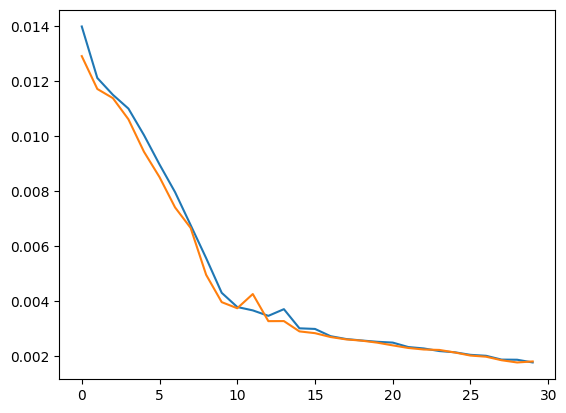

In [ ]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(input_dim,1)))
model.add(RepeatVector(input_dim))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
model.summary()
# fit model
history = model.fit(X_train, X_train, epochs=30, batch_size=10000, validation_data=(X_test, X_test))
# plot_model(model, show_shapes=True)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# demonstrate recreation
yhat = model.predict(X_test, verbose=0)
cfm = confusion_matrix(y_test, yhat)
print(cfm)

In [ ]:
print(y_test.to_numpy().sum())
len(y_test)


29799


149490

In [ ]:
X_test.to_numpy()

array([[0.        , 0.        , 0.        , ..., 0.00267554, 0.17630058,
        0.        ],
       [0.11764706, 0.44444444, 0.33333333, ..., 0.42305504, 0.05780347,
        0.        ],
       [0.11764706, 0.        , 0.        , ..., 0.00167797, 0.50289017,
        0.        ],
       ...,
       [0.17647059, 0.        , 0.        , ..., 0.00086232, 0.4132948 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00121877, 0.08381503,
        0.        ],
       [0.        , 0.33333333, 0.33333333, ..., 0.23133794, 0.23699422,
        0.        ]])

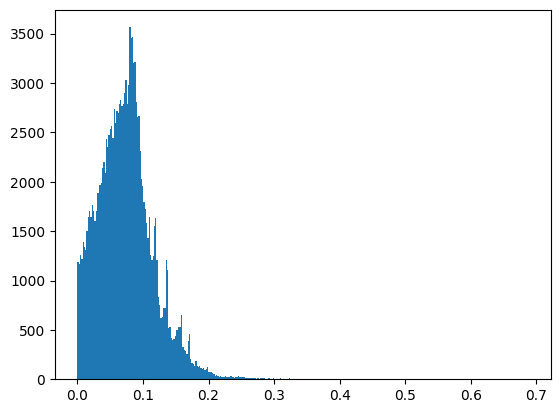

In [ ]:
# print(len(X_test[6]), len(yhat))
# print(yhat[6], X_test.iloc[6])
# plt.scatter(X_test[6], [x[6] for x in yhat])
X_test[6].to_numpy()
diff = [abs(sum(x) - sum(y))[0] for x, y in zip(X_test.to_numpy(), yhat)]
# for val in diff:
#     if val > 0.4
# diff = [X_test.loc[6], yhat]
# diff
# new_df = pd.DataFrame(columns=[X_test[6], yhat])
# print(abs(diff[0] - diff[1][6]))
# print([abs(x - y[6]) for x, y in diff])
plot = plt.hist(diff, bins='auto')

[Text(0, 0, '119687'), Text(0, 0, '29762')]

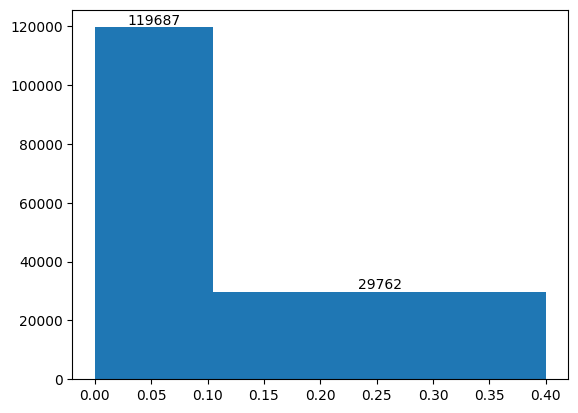

In [ ]:
counts, edges, bars = plt.hist(diff, bins=[0, 0.105, 0.4])
plt.bar_label(bars)

In [ ]:
# sum(plot[0][0] < 500)
plot[1]

array([3.65194865e-07, 7.14640482e-04, 1.42891577e-03, 2.14319094e-03,
       2.85746623e-03, 3.57174152e-03, 4.28601680e-03, 5.00029232e-03,
       5.71456738e-03, 6.42884290e-03, 7.14311795e-03, 7.85739347e-03,
       8.57166853e-03, 9.28594358e-03, 1.00002186e-02, 1.07144946e-02,
       1.14287697e-02, 1.21430447e-02, 1.28573198e-02, 1.35715958e-02,
       1.42858708e-02, 1.50001459e-02, 1.57144219e-02, 1.64286960e-02,
       1.71429720e-02, 1.78572480e-02, 1.85715221e-02, 1.92857981e-02,
       2.00000722e-02, 2.07143482e-02, 2.14286242e-02, 2.21428983e-02,
       2.28571743e-02, 2.35714484e-02, 2.42857244e-02, 2.50000004e-02,
       2.57142745e-02, 2.64285505e-02, 2.71428265e-02, 2.78571006e-02,
       2.85713766e-02, 2.92856507e-02, 2.99999267e-02, 3.07142027e-02,
       3.14284787e-02, 3.21427509e-02, 3.28570269e-02, 3.35713029e-02,
       3.42855789e-02, 3.49998549e-02, 3.57141271e-02, 3.64284031e-02,
       3.71426791e-02, 3.78569551e-02, 3.85712311e-02, 3.92855071e-02,
      

## LSTM w/ time series

In [ ]:

def get_days(x, i, current_time):
    start_day = current_time
    while current_time == start_day and i < len(x):
        current_time = x.iloc[i]['date']
        i+=1
    return i, current_time


def to_sequences(x, y):
    x_values = []
    y_values = []
    current_time = x['date'].iloc[0]
    end_time = x['date'].iloc[-1]
    j = 0
    while current_time <= end_time:
        step, next_day = get_days(x,j,current_time)
        if step < len(x):
            x_values.append(x.iloc[j:step].values)
            y_values.append(y.iloc[step])            
            current_time = next_day
        else:
            x_values.append(x.iloc[j:step-1].values)
            y_values.append(y.iloc[step-1])
            break   
        j=step
    return np.array(x_values), np.array(y_values)

In [23]:
def to_sequences_homogenous(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

In [20]:
elapsed = pd.to_datetime(df['date']).max().timestamp() - pd.to_datetime(df['date']).min().timestamp()
seq_size = len(df) // datetime.timedelta(seconds=elapsed).days

In [22]:
# xtrain, ytrain = to_sequences(df, df.drop('date', axis=1))
X, y = to_sequences_homogenous(df, df.drop('date', axis=1), seq_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

KeyboardInterrupt: 

In [ ]:
X_train.shape

(515,)

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(X_train.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

IndexError: tuple index out of range